# Test image ==> croping question rerion

In [3]:
from imutils.perspective import four_point_transform
from imutils import contours
import numpy as np
import argparse
import imutils
import cv2

In [4]:
import matplotlib.pyplot as plt
def show(img,figsize=(10,10)):
    plt.figure(figsize=figsize)
    plt.imshow(img)
    plt.show()

(2339, 1653, 3)


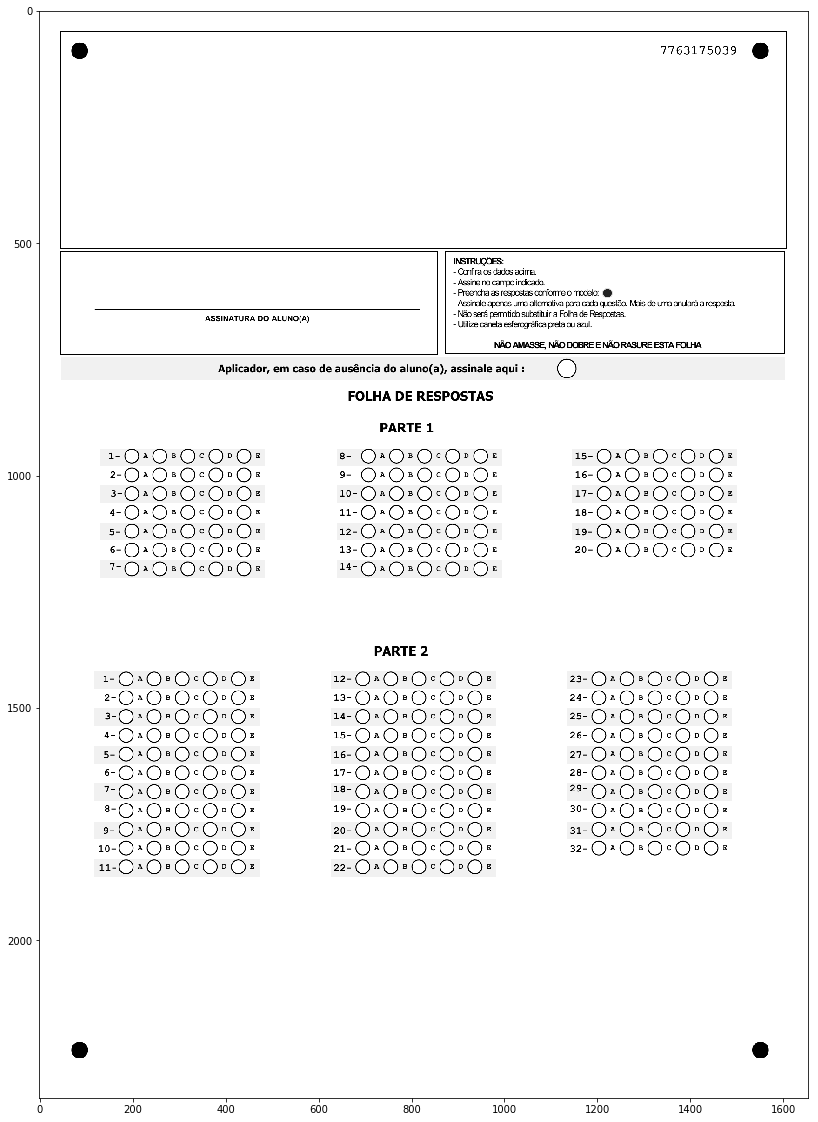

In [5]:
path = './templates/png/PT_AVALIA_20_32_AE.png'
# path = 'LOTE3/png/GABARITO 1_ELETRICISTA DE MANUTENCAO.png'

image = cv2.imread(path)
h,w,c = image.shape
print(image.shape)
show(image, (20,20))

point: 0


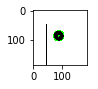

point: 1


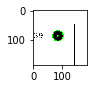

point: 2


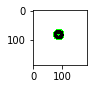

point: 3


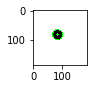

[[  87.           87.        ]
 [  84.6000061  1553.        ]
 [2239.           83.40000153]
 [2235.40000153 1549.40000153]]


In [9]:
s = int(0.08*h)

p0 = (int(0*h), int(0*w))
p1 = (int(0*h), int(w-s))
p2 = (int(h)-s, int(0*w))
p3 = (int(h)-s, int(w-s))

tips = [p0,p1,p2,p3]

for n,(y,x) in enumerate(tips):
    print("point: {}".format(n))
    
    test = image[y:y+s, x:x+s].copy()
    gray = cv2.cvtColor(test, cv2.COLOR_BGR2GRAY)
    
    circles = cv2.HoughCircles(gray, 
                               cv2.HOUGH_GRADIENT, 1.2,1000, 
                               param1=20,param2=10,minRadius=0,maxRadius=0)
    if circles is not None:
        for i in circles[0,:]:
            cv2.circle(test,(i[0],i[1]),i[2],(0,255,0),2)
            cv2.circle(test,(i[0],i[1]),2,(0,255,0),3)     
            tips[n] = (y+i[0],x+i[1])
    show(test, (1,1))
tips = np.array(tips)
print(tips)